# WHATSAPP GROUP CHAT ANALYSIS FOR FABULOUS FAMILY
My cousins family whatsapp group.
This project is to understand how we communicate and the sentiment that defins the chats. 
Lets Start!

In [0]:
#Import the text file we shall be using
#from google.colab import files
#chat = files.upload()

Install required packages

In [0]:
#!pip install emoji
#!pip install dateparser
#!pip install jovian

Import all required packages for the project

In [0]:
import re
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import emoji
from sklearn.feature_extraction.text import CountVectorizer
import random
from textblob import TextBlob
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

sns.set(rc={'figure.figsize':(14, 6)})

# Data Cleaning

In [0]:
def startsWithDate(s):
    pattern = '^([0-2][0-9]|(3)[0-1])(\/)(((0)[0-9])|((1)[0-2]))(\/)(\d{2}|\d{4}), ([0-9][0-9]):([0-9][0-9]) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [0]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '^(\+\d{1,2}\s)?\(?\d{3}\) ((\(\d{3}\) ?)|(\d{3}-))?\d{3}-\d{4}:',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{6}):',         # Mobile Number (Europe)
        '([+]\d{3} \d{3} \d{6})'           # Mobile Number (Uganda)
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [0]:
def getDataPoint(line):
    splitLine = line.split(' - ') # splitLine = ['18/06/17, 22:47', 'Loki: Why do you have 2 numbers, Banner?']
    
    dateTime = splitLine[0] # dateTime = '18/06/17, 22:47'
    
    #date, time = dateTime.split(', ') # date = '18/06/17'; time = '22:47'
    
    message = ' '.join(splitLine[1:]) # message = 'Loki: Why do you have 2 numbers, Banner?'
    
    if startsWithAuthor(message): # True
        splitMessage = message.split(': ') # splitMessage = ['Loki', 'Why do you have 2 numbers, Banner?']
        author = splitMessage[0] # author = 'Loki'
        message = ' '.join(splitMessage[1:]) # message = 'Why do you have 2 numbers, Banner?'
    else:
        author = None
    return dateTime, author, message

Parse the entire file and handle multi-line messages

In [0]:
parsedChat = []
convoPath = './fab_fam.txt'
with open(convoPath, encoding='utf-8') as fp:
    fp.readline
    messageBuffer = []
    dateTime, author = None, None

    while True:
        line = fp.readline()
        if not line:
            break
        line = line.strip()
        if startsWithDate(line):
            if len(messageBuffer) > 0:
                parsedChat.append([dateTime, author, ' '.join(messageBuffer)])
                messageBuffer.clear()
                dateTime, author, message = getDataPoint(line)
                messageBuffer.append(message)
            else:
                messageBuffer.append(line)   

In [8]:
df = pd.DataFrame(parsedChat, columns=['DateTime', 'Author', 'Message'])
df.head()

,DateTime,Author,Message
0,None,None,"26/12/2017, 12:28 - Pauline: Lena and Pauline ..."
1,"26/12/2017, 15:58",Joanna,Testing 3-5 outdoor venues by night today and ...
2,"26/12/2017, 22:45",Joanna,<Media omitted>
3,"28/12/2017, 21:14",Micheal,It will happen to you
4,"28/12/2017, 21:39",+256 792 754083,See yourself


In [9]:
df.tail()

,DateTime,Author,Message
7329,"25/12/2019, 12:40",Fina,Beautiful.
7330,"25/12/2019, 13:20",Joanna,Thank you😊🌹❤
7331,"25/12/2019, 13:20",Joanna,🤨🤔
7332,"25/12/2019, 18:47",Olivia Namulindwa,Merry Christmas Family🎄🎁 💝
7333,"26/12/2019, 16:58",Ben,<Media omitted>


In [10]:
df.describe()

,DateTime,Author,Message
count,7333,6882,7334
unique,5662,35,4929
top,"15/12/2019, 08:10",Joanna,<Media omitted>
freq,26,1300,1604


In [11]:
#no. of images, images are represented by <media omitted>
media = df[df['Message'] == "<Media omitted>"]
media.shape

(1604, 3)

This runs on the basis that Media excluded after the Whatsapp export is what is used to determine the following stats.

Text(0.5, 1.0, 'Most Media Items sent per Author')

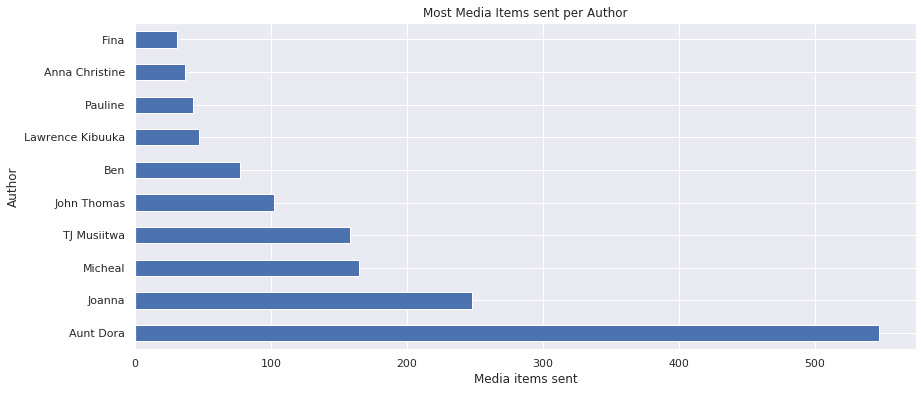

In [12]:
author_media_messages_value_counts = media['Author'].value_counts()
top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
top_10_author_media_messages_value_counts.plot.barh()
plot.ylabel('Author')
plot.xlabel('Media items sent')
plot.title('Most Media Items sent per Author')

In [13]:
#Number of group notifications
grp_notif = df[df['Author']=="grp_notif"] 
grp_notif.shape

(0, 3)

In [14]:
message_deleted = df[df['Message'] == "This message was deleted"]
message_deleted.shape

(93, 3)

Who deletes the most messages in the group.Since the new feature was announced by Whatsapp.

Text(0.5, 0, 'Messaged Deleted')

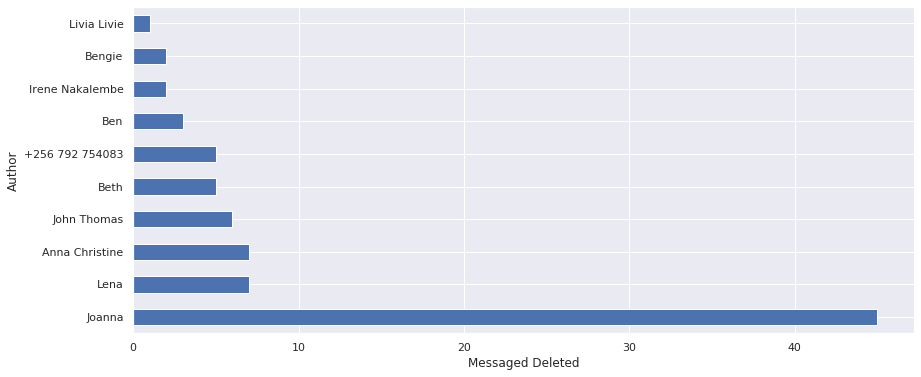

In [15]:
author_messages_deleted_value_counts = message_deleted['Author'].value_counts()
top10_author_messages_deleted_value_counts = author_messages_deleted_value_counts.head(10)
top10_author_messages_deleted_value_counts.plot.barh()
plot.ylabel('Author')
plot.xlabel('Messaged Deleted')

In [0]:
#Drop the media ommitted messages and group notifications and deleted messages
df.drop(media.index, inplace=True)
df.drop(grp_notif.index, inplace=True)
df.drop(message_deleted.index, inplace=True)

In [17]:
#Find the null values
df.isnull().sum()

DateTime      1
Author      452
Message       0
dtype: int64

In [0]:
#Drop empty rows with tina
df = df.dropna()

In [19]:
df.reset_index(inplace=True, drop=True)
df.shape

(5185, 3)

Add the dateTime object from dateTime column

In [0]:
df['dateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)

In [0]:
df['Day_of_Week'] = pd.Series(pd.Categorical(df['dateTime'].dt.weekday_name, categories=list(calendar.day_name)))
df['Hour'] = pd.Series(pd.Categorical(df['dateTime'].dt.hour))

In [0]:
df = df.set_index('dateTime') 

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5185 entries, 2017-12-26 15:58:00 to 2019-12-25 18:47:00
Data columns (total 5 columns):
DateTime       5185 non-null object
Author         5185 non-null object
Message        5185 non-null object
Day_of_Week    5185 non-null category
Hour           5185 non-null category
dtypes: category(2), object(3)
memory usage: 173.3+ KB


In [24]:
df.head()

,DateTime,Author,Message,Day_of_Week,Hour
dateTime,,,,,
2017-12-26 15:58:00,"26/12/2017, 15:58",Joanna,Testing 3-5 outdoor venues by night today and ...,Tuesday,15
2017-12-28 21:14:00,"28/12/2017, 21:14",Micheal,It will happen to you,Thursday,21
2017-12-28 21:39:00,"28/12/2017, 21:39",+256 792 754083,See yourself,Thursday,21
2017-12-28 23:12:00,"28/12/2017, 23:12",Beth,"23/12/2017, 23:42:10 ‪+256 701 839948‬ BEWARE....",Thursday,23
2017-12-29 15:36:00,"29/12/2017, 15:36",Micheal,Tina ng'okaye,Friday,15


# Data Exploration

In [25]:
df.describe()

,DateTime,Author,Message,Day_of_Week,Hour
count,5185,5185,5185,5185,5185
unique,4309,35,4595,7,24
top,"02/11/2018, 07:49",Joanna,Amen,Sunday,9
freq,8,1007,35,983,460


Text(0.5, 1.0, 'The Top 10 Most Talkative Persons')

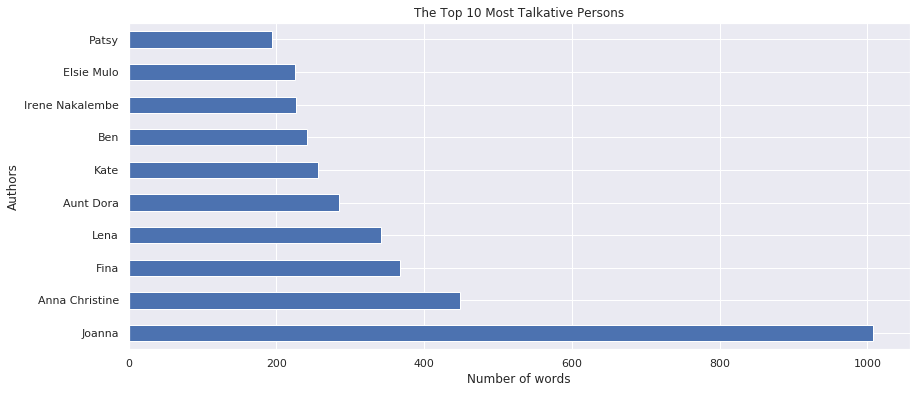

In [26]:
author_value_counts = df['Author'].value_counts()
top10_talkers = author_value_counts.head(10)
top10_talkers.plot.barh()
plot.xlabel('Number of words')
plot.ylabel('Authors')
plot.title('The Top 10 Most Talkative Persons')

In [0]:
df['Date'] = df['DateTime'].apply(lambda t: t.split(',')[0])

Text(0, 0.5, 'Number of messages')

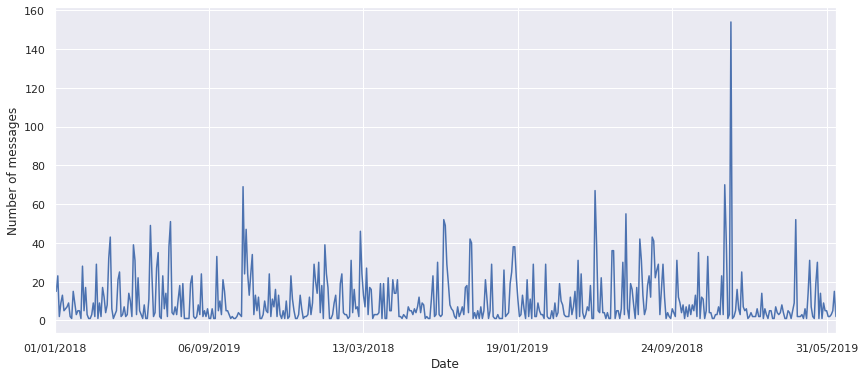

In [28]:
df.groupby('Date')['Message'].count().plot()
plot.ylabel('Number of messages')

In [0]:
df['Time'] = df['DateTime'].apply(lambda t: t.split(',')[1])

Text(0, 0.5, 'Number of messages')

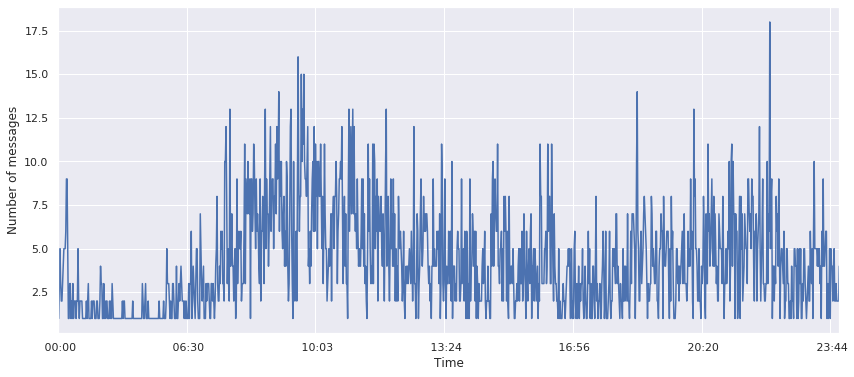

In [30]:
df.groupby('Time')['Message'].count().plot()
plot.ylabel('Number of messages')

Text(0, 0.5, 'Number of messages')

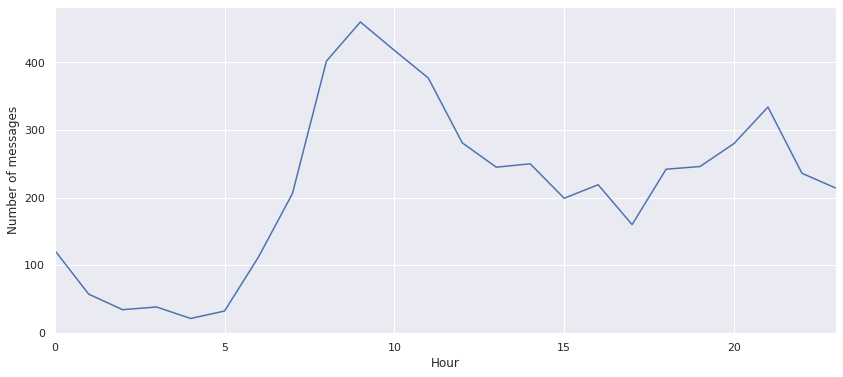

In [31]:
df.groupby('Hour')['Message'].count().plot()
plot.ylabel('Number of messages')

Let's understand the number of letters and words used by each author in each message.

In [0]:
df['Letter_Count'] = df['Message'].apply(lambda s : len(s))
df['Word_Count'] = df['Message'].apply(lambda s : len(s.split(' ')))

In [33]:
df.head()

,DateTime,Author,Message,Day_of_Week,Hour,Date,Time,Letter_Count,Word_Count
dateTime,,,,,,,,,
2017-12-26 15:58:00,"26/12/2017, 15:58",Joanna,Testing 3-5 outdoor venues by night today and ...,Tuesday,15,26/12/2017,15:58,86,15
2017-12-28 21:14:00,"28/12/2017, 21:14",Micheal,It will happen to you,Thursday,21,28/12/2017,21:14,21,5
2017-12-28 21:39:00,"28/12/2017, 21:39",+256 792 754083,See yourself,Thursday,21,28/12/2017,21:39,12,2
2017-12-28 23:12:00,"28/12/2017, 23:12",Beth,"23/12/2017, 23:42:10 ‪+256 701 839948‬ BEWARE....",Thursday,23,28/12/2017,23:12,67,7
2017-12-29 15:36:00,"29/12/2017, 15:36",Micheal,Tina ng'okaye,Friday,15,29/12/2017,15:36,13,2


Describe the continuous and discrete variables

In [34]:
print('Total Letter count in the group:' + str(df['Letter_Count'].sum())) 
print('Total Word count in the group:' + str(df['Word_Count'].sum()))

Total Letter count in the group:210965
Total Word count in the group:38057


What is the most common number of words in a message?

Text(0, 0.5, 'Frequency')

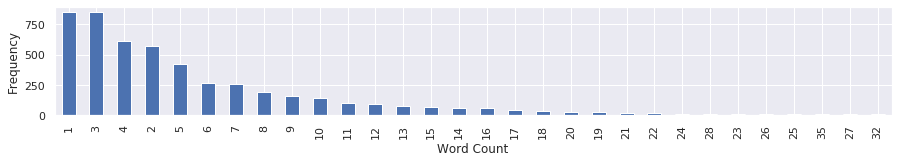

In [35]:
plot.figure(figsize=(15,2))
word_count_value_counts = df['Word_Count'].value_counts()
top40_word_count = word_count_value_counts.head(30)
top40_word_count.plot.bar()
plot.xlabel('Word Count')
plot.ylabel('Frequency')

So who exactly writes the most letters?

Text(0, 0.5, 'Authors')

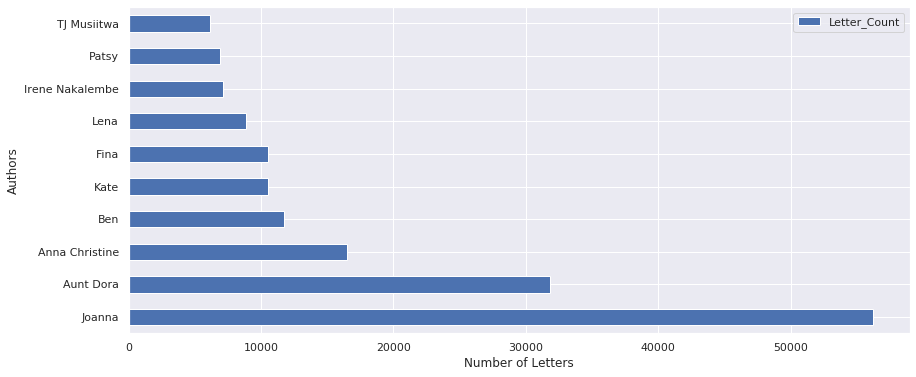

In [36]:
total_letter_count_by_author = df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_by_author = total_letter_count_by_author.sort_values('Letter_Count', ascending=False)
top10_sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_by_author.head(10)
top10_sorted_total_letter_count_grouped_by_author.plot.barh()
plot.xlabel('Number of Letters')
plot.ylabel('Authors')

Text(0, 0.5, 'Authors')

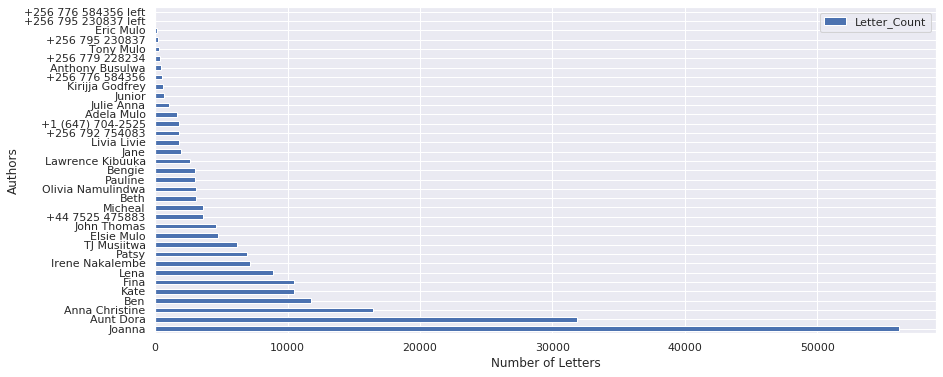

In [37]:
total_letter_count_by_author = df[['Author', 'Letter_Count']].groupby('Author').sum()
sorted_total_letter_count_by_author = total_letter_count_by_author.sort_values('Letter_Count', ascending=False)
sorted_total_letter_count_grouped_by_author = sorted_total_letter_count_by_author
sorted_total_letter_count_grouped_by_author.plot.barh()
plot.xlabel('Number of Letters')
plot.ylabel('Authors')

Most common number of letter per message?

Text(0, 0.5, 'Frequency')

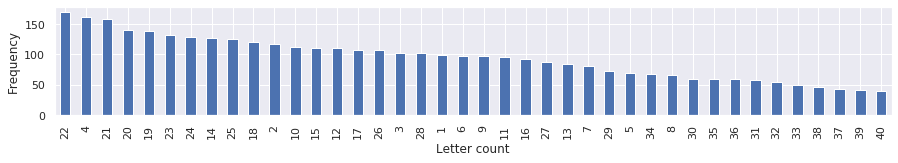

In [38]:
plot.figure(figsize=(15, 2))
letter_count_value_counts = df['Letter_Count'].value_counts()
top40_letter_count_value_counts = letter_count_value_counts.head(40)
top40_letter_count_value_counts.plot.bar()
plot.xlabel('Letter count')
plot.ylabel('Frequency')

When was the group most active?

Text(0, 0.5, 'Day of the Week')

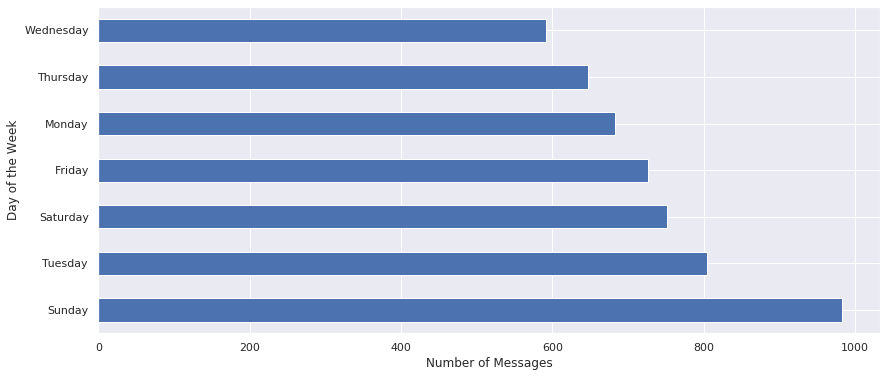

In [39]:
df['Day_of_Week'].value_counts().plot.barh()
plot.xlabel('Number of Messages')
plot.ylabel('Day of the Week')

Any particular dates in question?

Text(0, 0.5, 'Date')

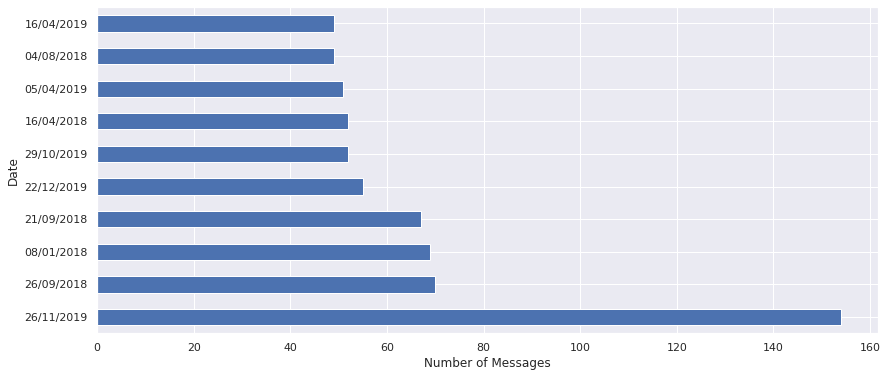

In [40]:
df['Date'].value_counts().head(10).plot.barh() # Top 10 Dates on which the most number of messages were sent
plot.xlabel('Number of Messages')
plot.ylabel('Date')

The most active hour

The most suitable time of day to get your message replied to

Text(0, 0.5, 'Hour')

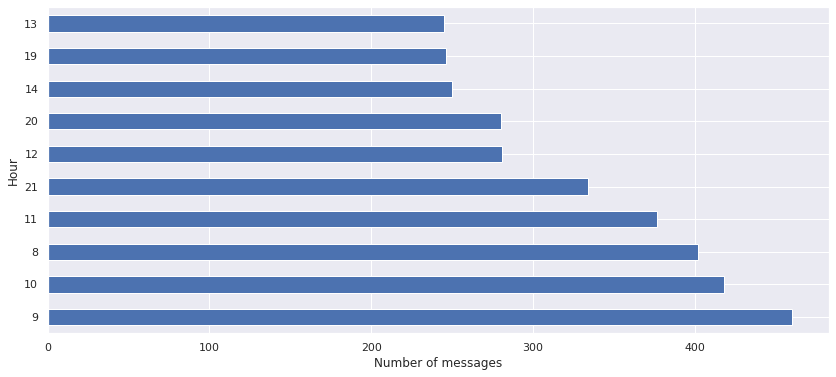

In [41]:
df['Hour'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plot.xlabel('Number of messages')
plot.ylabel('Hour')

When the most kaboozi happens?

Text(0, 0.5, 'Time')

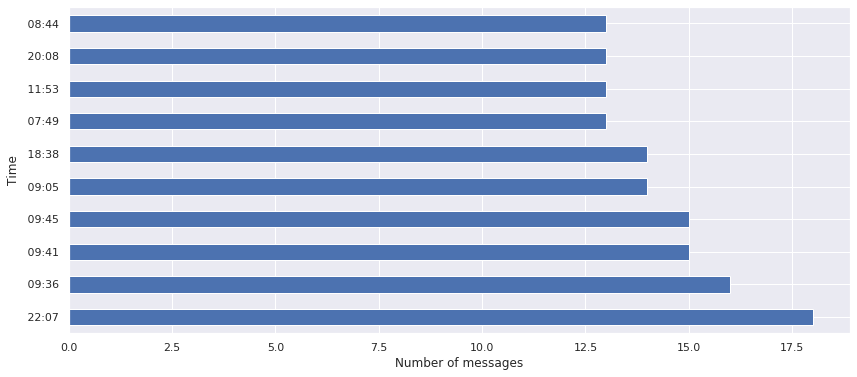

In [42]:
df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plot.xlabel('Number of messages')
plot.ylabel('Time')

What are the most commonly used words?

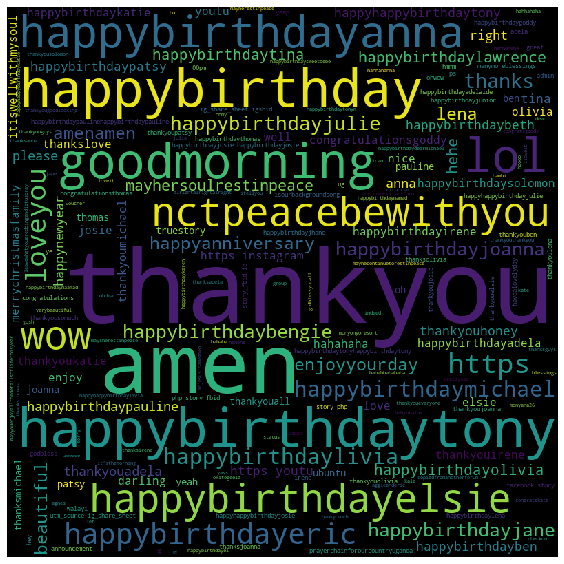

In [43]:
comment_words = ''
for val in df['Message'].values:
  val = str(val)
  tokens = val.split()

  for i in range(len(tokens)):
    tokens[i] = tokens[i].lower()

  for words in tokens:
    comment_words = comment_words + words + ''

famcloud = WordCloud(width=800, height=800).generate(comment_words)

plot.figure(figsize=(8,8))
plot.imshow(famcloud)
plot.axis('off')
plot.tight_layout()

plot.show()


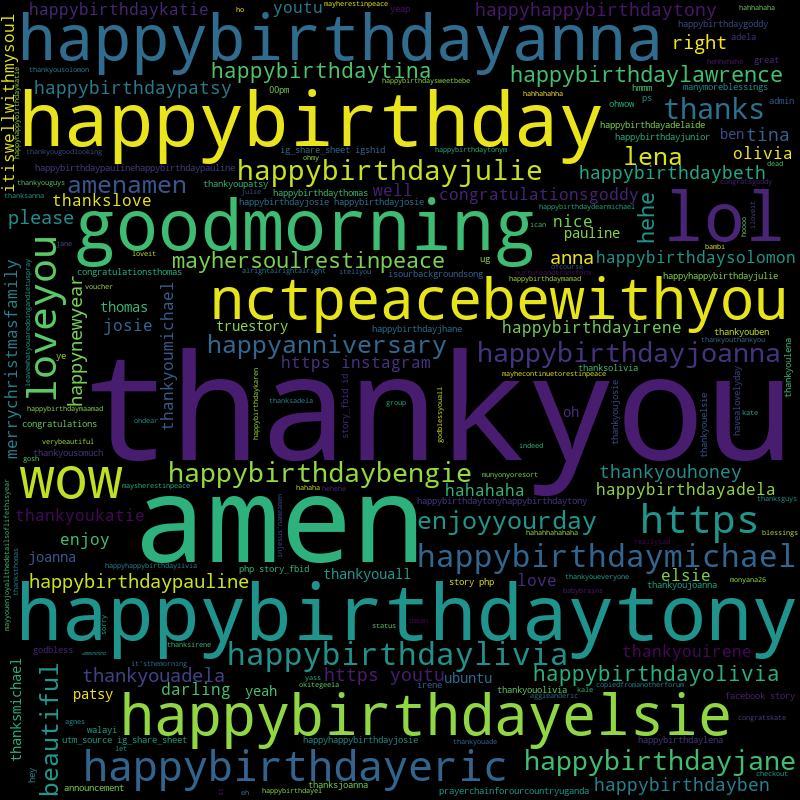

In [44]:
#If you wish to download the image, run the cell
famcloud.to_image()

Count all my most used emojis

In [45]:
df['Author'].unique()

array(['Joanna', 'Micheal', '+256 792 754083', 'Beth', 'Aunt Dora',
       'Kate', 'Anna Christine', 'TJ Musiitwa', 'Ben', 'Anthony Busulwa',
       '+1 (647) 704-2525', 'Patsy', 'Irene Nakalembe', 'Lena',
       'Olivia Namulindwa', 'Lawrence Kibuuka', 'Fina', 'Junior',
       'Julie Anna', 'Elsie Mulo', 'Tony Mulo', 'Pauline', 'Livia Livie',
       '+256 776 584356 left', 'Bengie', 'John Thomas', '+44 7525 475883',
       '+256 795 230837', '+256 776 584356', 'Jane',
       '+256 795 230837 left', 'Adela Mulo', 'Kirijja Godfrey',
       'Eric Mulo', '+256 779 228234'], dtype=object)

In [46]:
#To find your own most used emojis, just run the above cell to find your name
# and insert it where my name is...
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
  if row['Author'] == 'TJ Musiitwa':
    emojis_found = r.findall(row['Message'])
    for emoji_found in emojis_found:
      emoji_ctr[emoji_found] += 1
for item in emoji_ctr.most_common(10):
  print(item[0] + ' - '+ str(item[1]))      

😅 - 17
😆 - 13
🏾 - 7
😁 - 4
👀 - 3
👏 - 2
🤷 - 2
♂ - 2
🤣 - 2
🕺 - 1


In [0]:
def extract_emojis(str):
  return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

In [48]:
len(set(df['Message'].apply(lambda x: extract_emojis(x)).sum()))

221

Find out the group's top 20 emoji usage

In [49]:
emojiGrpCtr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row['Message'])
    for emoji_found in emojis_found:
      emojiGrpCtr[emoji_found] += 1
for item in emojiGrpCtr.most_common(20):
  print(item[0] + ' - '+ str(item[1]))   

🤣 - 797
😂 - 627
🤗 - 466
😘 - 318
🏽 - 302
❤ - 223
😍 - 198
👏 - 163
🏾 - 153
🎉 - 103
♀ - 93
🙏 - 80
😊 - 73
🎂 - 66
🥰 - 61
🏃 - 57
💃 - 56
🙆 - 54
🏼 - 51
🤔 - 50


In [0]:
emojiGrp = pd.DataFrame.from_dict(emojiGrpCtr, orient='index').reset_index()

In [0]:
emojiGrp = emojiGrp.rename(columns={'index':'Emoji', 0:'Count'})

In [52]:
emojiGrp.head()

,Emoji,Count
0,👀,16
1,🤙,5
2,😂,627
3,🎵,1
4,🎶,1


# Data Analysis

This section is going to cover understanding the text that flows in the group conversations with topic modeling and the like

Topic Modeling

##Latent Dirichlet Allocation

In [0]:
count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
term_matrix = count_vect.fit_transform(df['Message'].values.astype('U'))

In [54]:
term_matrix

<5185x2140 sparse matrix of type '<class 'numpy.int64'>'
	with 16469 stored elements in Compressed Sparse Row format>

In [55]:
LDA = LatentDirichletAllocation(n_components=10,random_state=43)
LDA.fit(term_matrix)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=43, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [56]:
for i in range(10):
  random_id = random.randint(0,len(count_vect.get_feature_names()))
  print(count_vect.get_feature_names()[random_id])

chartered
trillion
pa
jonathan
lost
5th
security
lot
kebba
40


In [0]:
first_topic = LDA.components_[0]
top_topic_words = first_topic.argsort()[-10:]

In [58]:
for i in top_topic_words:
    print(count_vect.get_feature_names()[i])

got
christmas
sorry
family
eh
guys
lovely
just
beautiful
ben


In [59]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['got', 'christmas', 'sorry', 'family', 'eh', 'guys', 'lovely', 'just', 'beautiful', 'ben']


Top 10 words for topic #1:
['kitalo', 'https', 'jose', 'hi', 'joan', 'baby', 'dear', 'bambi', 'irene', 'thanks']


Top 10 words for topic #2:
['waiting', 'end', 'just', 'mu', 'shall', 'month', 'jesus', 'lena', 'amen', 'thank']


Top 10 words for topic #3:
['sad', 'news', 'jt', 'really', 'uganda', 'people', 'party', 'time', 'kate', 'congratulations']


Top 10 words for topic #4:
['jane', 'goddy', 'josie', 'anniversary', 'livia', 'elsie', 'lol', 'tony', 'birthday', 'happy']


Top 10 words for topic #5:
['hun', 'thanx', 'look', 'need', 'like', 'nice', 'soul', 'joanna', 'rest', 'peace']


Top 10 words for topic #6:
['meeting', 'hbd', 'joana', 'family', 'congrats', 'beth', 'solomon', 'thomas', 'morning', 'good']


Top 10 words for topic #7:
['just', 'bless', 'great', 'good', 'don', 'lord', 'oh', 'haha', 'yes', 'god']


Top 10 words for topic #8:
['week', 'hahaha', 'family

##Non-Negative Matrix Factorization (NMF)

In [0]:
fam_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')
doc_matrix = fam_vect.fit_transform(df['Message'].values.astype('U'))

In [0]:
fam_nmf = NMF(n_components=10, random_state=42)
fam_topics = fam_nmf.fit(doc_matrix)

In [0]:
t = np.argmax(fam_topics)

In [63]:
fab_topic = fam_nmf.components_[0]
topic_words = fab_topic.argsort()[-10:]
for i in topic_words:
    print(fam_vect.get_feature_names()[i])

josie
irene
goddy
julie
eric
anna
jane
livia
birthday
happy


In [64]:
for i,topic in enumerate(fam_nmf.components_):
    print(f'Top 10 words for topic #{i}:')
    print([fam_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['josie', 'irene', 'goddy', 'julie', 'eric', 'anna', 'jane', 'livia', 'birthday', 'happy']


Top 10 words for topic #1:
['michael', 'honey', 'solomon', 'ben', 'joanna', 'adela', 'elsie', 'lena', 'irene', 'thank']


Top 10 words for topic #2:
['michael', 'adela', 'irene', 'guys', 'lena', 'joanna', 'patsy', 'anna', 'elsie', 'thanks']


Top 10 words for topic #3:
['chribi', 'khate', 'anna', 'mercy', 'maama', 'lord', 'kate', 'tina', 'jesus', 'amen']


Top 10 words for topic #4:
['tina', 'blessings', 'lots', 'day', 'guys', 'patsy', 'family', 'beautiful', 'thanx', 'love']


Top 10 words for topic #5:
['sad', 'kitalo', 'condolences', 'oh', 'bambi', 'continue', 'nct', 'soul', 'rest', 'peace']


Top 10 words for topic #6:
['fab', 'looking', 'people', 'time', 'god', 'day', 'family', 'night', 'morning', 'good']


Top 10 words for topic #7:
['hope', 'joanna', 'person', 'sorry', 'thomas', 'hbd', 'agaba', 'happy', 'birthday', 'tony']


Top 10 words for topic #8:
['congrats

##Sentiment Analysis

In [0]:
df['Polarity'] = df['Message'].map(lambda text: TextBlob(text).sentiment.polarity)

Randomly select 5 reviews with the highest positive sentiment polarity score 

In [66]:
print('5 random reviews with the highest positive sentiment polarity: \n')
cl = df.loc[df['Polarity'] == 1, ['Message']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the highest positive sentiment polarity: 

Happy birthday Beth!
Happy birthday Tony!!!
Happy anniversary!
Happy Birthday Maama Dora!! 💝
Happy birthday Irene! 🤗🤗😘


Randomly select 5 reviews with the most neutral sentiment polarity score 

In [67]:
print('5 random reviews with the most neutral sentiment(zero) polarity: \n')
cl = df.loc[df['Polarity'] == 0, ['Message']].sample(5).values
for c in cl:
    print(c[0])

5 random reviews with the most neutral sentiment(zero) polarity: 

👆🏾not my words, sent as received
CAN A CHRISTIAN DRINK ALCOHOL? Pro 31  2 7
🎂Happy birthday Livia🎂
🤗🤗🤗
What time?


In [68]:
print('5 reviews with the most negative polarity: \n')
cl = df.loc[df['Polarity'] == -0.50, ['Message']].sample(5).values
for c in cl:
    print(c[0])

5 reviews with the most negative polarity: 

Wrong forum 😎😎😎
Really sad
I feel so sad.
Sorry may
Bambi sad. may her soul rest in peace


The distribution of review sentiment polarity score

(array([2.000e+00, 1.100e+01, 5.900e+01, 7.800e+01, 9.100e+01, 3.318e+03,
        2.960e+02, 3.470e+02, 1.680e+02, 8.150e+02]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

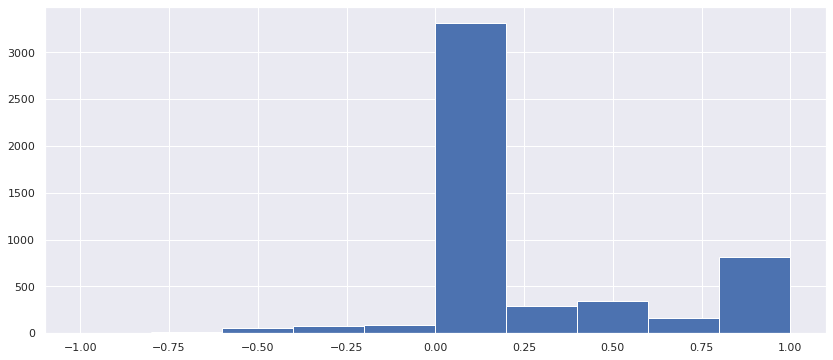

In [69]:
plot.hist('Polarity', data=df)